#Conditional GAN Implementation (Pix2Pix)

## 1. Architecture

### 1.1 Discriminator Model

The Disciminator is a patchGAN which consists of 4 CNN layers:
* $C64-C128-C256-C512$
* BatchNorm is not
applied to the first C64 layer. 
* All ReLUs are leaky, with
slope 0.2

In [ ]:
import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
        # last layer, map to a 1 dimensional output
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

### 1.2 Generator

The Generator is a U-net:
* encoder:
$C64-C128-C256-C512-C512-C512-C512-C512$
* decoder : $CD512-CD512-CD512-C512-C256-C128-C64$
* skip connections between layer $i$ and $n-i$, $n$ is number of layers

In [ ]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


## 2. Data preparation

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

%cd content/drive/MyDrive/INF8225_TP4/


Mounted at /content/drive
[Errno 2] No such file or directory: 'content/drive/MyDrive/INF8225_TP4/'
/content


In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"
!pip install albumentations==0.4.6

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 952kB 8.8MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
albumentations==0.5.2 is successfully installed
     |████████████████████████████████| 122kB 5.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=ffe9aab57a285b6e64713ae0c605ff80b0f5d27afead93dc9cc0d5c2bad39cef
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic
!unzip comic-faces-paired-synthetic.zip -d face2Comics/

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "face2Comics/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/"
VAL_DIR = "facades/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "/content/drive/MyDrive/INF8225_TP4/face2Comics/disc.pth.tar"
CHECKPOINT_GEN = "/content/drive/MyDrive/INF8225_TP4/face2Comics/gen.pth.tar"
both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

### 2.1 Datasets

#### 2.1.1 MapDataset

In [ ]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.face_root = root_dir + "face"
        self.comic_root = root_dir + "comics"

        self.root_dir = root_dir
        self.list_face_files = os.listdir(self.face_root)
        self.list_comic_files = os.listdir(self.comic_root)

    def __len__(self):
        return len(self.list_face_files)

    def __getitem__(self, index):
        img_face_file = self.list_face_files[index]
        img_face_path = os.path.join(self.face_root, img_face_file)
        image_face = np.array(Image.open(img_face_path))

        img_comic_file = self.list_comic_files[index]
        img_comic_path = os.path.join(self.comic_root, img_comic_file)
        image_comic = np.array(Image.open(img_comic_path))

        augmentations = both_transform(image=image_face, image0=image_comic)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

#### 2.1.2 ComicsDataset

In [ ]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A

face2comics_path = 'face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'

class ComicsDataset(Dataset):
    def __init__(self, root_dir, transforms=None, train=True):
        self.root_dir = root_dir
        self.face_dir = os.path.join(self.root_dir, 'face')
        self.comics_dir = os.path.join(self.root_dir, 'comics')
        self.faces_list_files = os.listdir(self.face_dir)[:8000] if train else os.listdir(self.face_dir)[8000:]
        self.comics_list_files = os.listdir(self.comics_dir)[:8000] if train else os.listdir(self.comics_dir)[8000:]
        self.transforms = transforms

    def __len__(self):
        return len(self.faces_list_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.face_dir, self.faces_list_files[index])
        input_image = np.array(Image.open(img_path))
        target_path = os.path.join(self.comics_dir, self.comics_list_files[index])
        target_image = np.array(Image.open(target_path))

        #input_image = image[:, :600, :]
        #target_image = image[:, 600:, :]

        if self.transforms:
          input_image = self.transforms(input_image)
          target_image = self.transforms(target_image)
                
        return input_image, target_image

#### 2.1.3 Cars Dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download 'jessicali9530/stanford-cars-dataset'
! unzip stanford-cars-dataset.zip

In [ ]:
from PIL import Image, ImageFilter
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
from tqdm import tqdm
from torchvision import  transforms
import torchvision
import os
from tqdm import tqdm

def preprocess_data(files_path, dataset_max_size):
  '''
  create to array of numpy array
  @ files_path: directory of list of images
  return a tuple (natural images,edges)
  '''
  naturals, edges = [],[]
  file_paths= tqdm(os.listdir(files_path)[:dataset_max_size],position=0,leave=True)
  for file_path in file_paths:
    img = Image.open(os.path.join(files_path, file_path))
    if len(np.array(img).shape) < 3:
      continue
    edge = np.array(img.convert("L").filter(ImageFilter.FIND_EDGES).convert('RGB'))

    naturals.append(np.array(img))
    edges.append(edge)

  return (naturals, edges)


TRAIN_DIR = 'cars_train/cars_train/'
TEST_DIR = 'cars_test/cars_test/'

class CarsDataset(Dataset):
  '''
  Performs preprocessing of the car images with generation of the edges 
  '''
  def __init__(self, files_dir, dataset_max_size = 6500):
    self.data = preprocess_data(files_dir, dataset_max_size)
    self.transforms = transforms

  def __len__(self):
    return len(self.data[0])

  def __getitem__(self, index):
    augmentations = both_transform(image=self.data[0][index], image0=self.data[1][index])
    input_image = augmentations["image"]
    target_image = augmentations["image0"]

    input_image = transform_only_input(image=input_image)["image"]
    target_image = transform_only_mask(image=target_image)["image"]
                
    return target_image,input_image

### 2.2 Utilitary functions

In [ ]:
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/gen/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(y * 0.5 + 0.5, folder + f"/real/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## 3. Training

We use BCE Loss defined by : 
\begin{equation}
\ell(x, y)=L=\left\{l_{1}, \ldots, l_{N}\right\}^{\top}, \quad l_{n}=-\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]
\end{equation}
This function provides the calculation of both log components in the objective function (i.e. $log(D(x))$ and $log(1−D(G(z))$). We select either one by playing with the $y$ component in the equation.

In [ ]:
*import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm.notebook as tq
from torchvision.utils import save_image

torch.backends.cudnn.benchmark = True


def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    loop = tq.tqdm_notebook(train_loader,position=epoch, leave=True,)
    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:

          loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )
    return L1.item() ,D_fake_loss.item()

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler


VALIDATION_SPLIT = 0.2
dataset = MapDataset(root_dir=TRAIN_DIR)
dataset_size = dataset.__len__()

indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler)

In [ ]:
disc = Discriminator(in_channels=3).to(DEVICE)
gen = Generator(in_channels=3, features=64).to(DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()
D_real_log = []
D_fake_log = []
if LOAD_MODEL:
  load_checkpoint(
    CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
    )
  load_checkpoint(
    CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
    )

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()


for epoch in range(NUM_EPOCHS):
    d_real, d_fake = train_fn(
        disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
    )
    D_real_log.append(d_real)
    D_fake_log.append(d_fake)
    if not epoch%20 or epoch == 1:
      save_some_examples(gen, validation_loader, epoch, folder="/content/drive/MyDrive/if8225_finale/face")

KeyboardInterrupt: ignored

In [ ]:
save_some_examples(gen, validation_loader, epoch, folder="/content/drive/MyDrive/if8225_finale/face")

In [ ]:
# save_checkpoint(gen, opt_gen, filename="/content/drive/MyDrive/if8225_finale/gen")
save_checkpoint(disc, opt_disc, filename="/content/drive/MyDrive/if8225_finale/disc")

=> Saving checkpoint


## 4. Results

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Generator Loss')

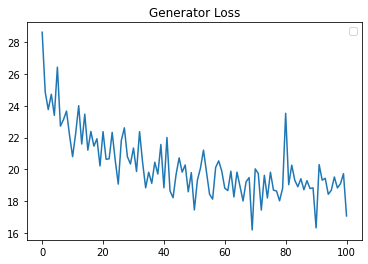

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(D_real_log)
plt.legend(loc='best')
plt.xlabel("")
plt.title("Generator Loss")

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Discriminator Loss')

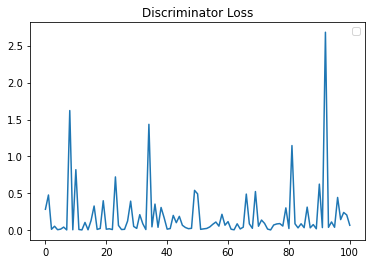

In [ ]:

plt.figure()
plt.plot(D_fake_log)
plt.legend(loc='best')
plt.title("Discriminator Loss")

In [ ]:
gen_saved = Generator(in_channels=3, features=64).to(DEVICE)
opt_gen_saved = optim.Adam(gen_saved.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

load_checkpoint("/content/drive/MyDrive/if8225_finale/gen",gen_saved,opt_gen_saved,LEARNING_RATE)



=> Loading checkpoint


In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(val_loader)
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"gen/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(y * 0.5 + 0.5, folder + f"real/label_{epoch}.png")
    gen.train()

In [ ]:
validation_loader = iter(validation_loader)

In [ ]:
for i in range(200):
  save_some_examples(gen_saved, validation_loader, i, folder="/content/drive/MyDrive/if8225_finale/niveau_bhay/")

### 3.1 FJD Metric
######*Did Not Use

In [ ]:

%matplotlib inline
import numpy as np

import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from fjd_metric import FJDMetric



class GANWrapper:
    def __init__(self, model, model_checkpoint=None):
        self.model = model
        
        if model_checkpoint is not None:
            self.model_checkpoint = model_checkpoint
            self.load_model()

    def load_model(self):
        # self.model.eval()  # uncomment to put in eval mode if desired
        self.model = self.model.cuda()

        state_dict = torch.load(self.model_checkpoint)
        self.model.load_state_dict(state_dict)

    def get_noise(self, batch_size):
        # change the noise dimension as required
        z = torch.cuda.FloatTensor(batch_size, 128).normal_()
        return z

    def __call__(self, y):
        batch_size = y.size(0)
        z = self.get_noise(batch_size)
        samples = self.model(z, y)
        return samples

inception_embedding = InceptionEmbedding(parallel=False)
onehot_embedding = OneHotEmbedding(num_classes=10)
gan = GANWrapper(gan)

fjd_metric = FJDMetric(gan=gan,
                       reference_loader=train_loader,
                       condition_loader=test_loader,
                       image_embedding=inception_embedding,
                       condition_embedding=onehot_embedding,
                       reference_stats_path='datasets/cifar_train_stats.npz',
                       save_reference_stats=True,
                       samples_per_condition=1,
                       cuda=True)

### 3.2 FID Metric

In [ ]:
!pip install pytorch-fid

!python -m pytorch_fid /content/drive/MyDrive/INF8225_TP4/maps/results/gen1 /content/drive/MyDrive/INF8225_TP4/maps/results/real1

For visual results in different epochs, please see:
* https://drive.google.com/drive/folders/1LM9PrPCS7MoPZCFvbohcI5yWx4N3yK0_
* https://drive.google.com/drive/folders/13tdJZnJ1ZbENiVSZhQ5AQ7poC3goxQ5v